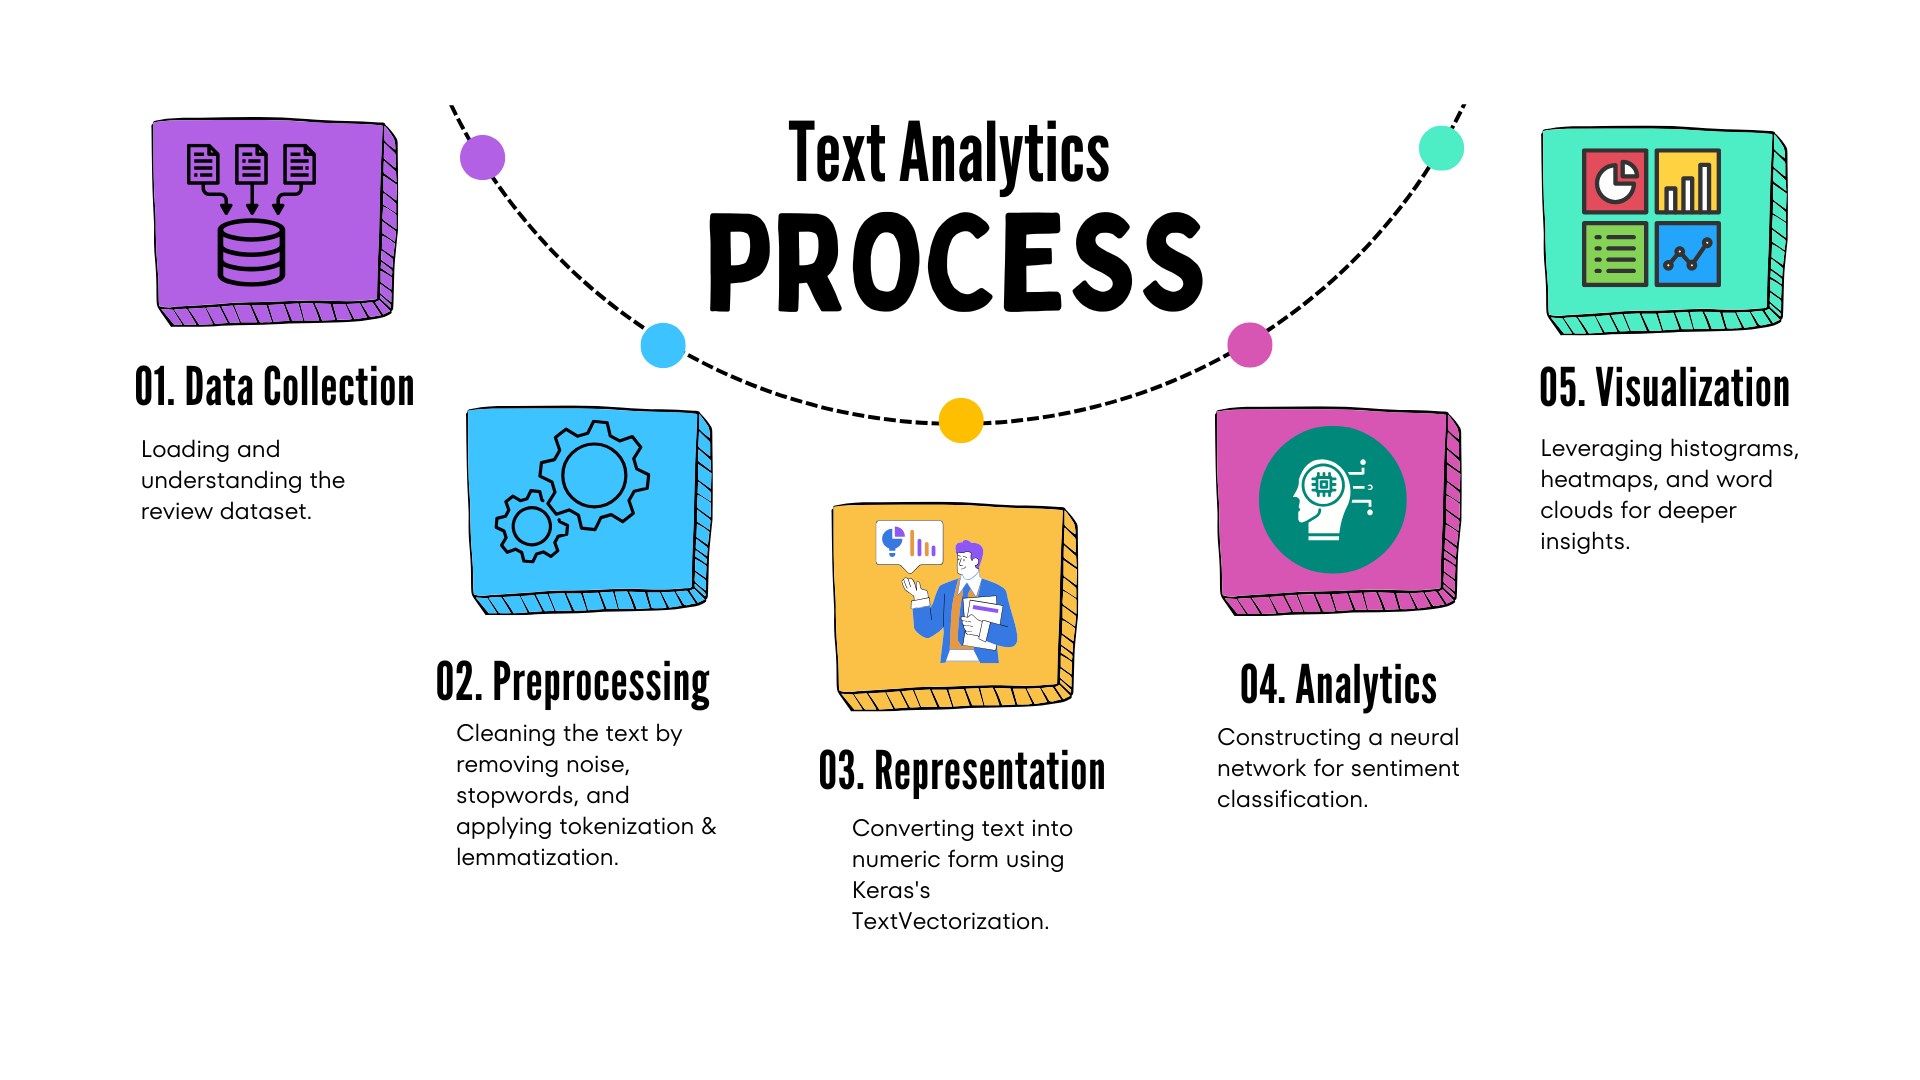

# **TEXT ANALYTICS PIPELINE**

### **WITH FLIPKART PRODUCT REVIEW DATASET**

### REG_NO: P15/1914/2022 NAME: OMUSE PRISCILLA ALAKARA

This notebook walks through a complete Text Analytics Pipeline using a real-world Flipkart product review dataset.
Our main goal is to showcase the steps of a text analytics pipeline while building a sentiment analysis model that can classify product reviews as positive or negative, clearly explaining each step in the process.

The following steps are covered:

1. Data Collection – Loading and understanding the review dataset.

2. Data Preprocessing – Cleaning the text by removing noise, stopwords, and applying tokenization & lemmatization.

3. Text Representation – Converting text into numeric form using Keras's TextVectorization.

4. Model Building & Training – Constructing a neural network for sentiment classification.

5. Model Evaluation – Using metrics like accuracy, F1-score, and confusion matrix to judge performance.

6. Insight Generation & Visualization – Leveraging histograms, heatmaps, and word clouds for deeper insights.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## **1. DATA COLLECTION**
 We use the Flipkart product review dataset, which contains the following columns:
 - ProductName
 - Price
 - Rate
 - Review
 - Summary

 The dataset is downloaded as a CSV file from Kaggle.
 We load it using pandas:

In [ ]:
path = '/content/drive/My Drive/DATASETS/flipkart_product.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')
df.columns

Index(['ProductName', 'Price', 'Rate', 'Review', 'Summary'], dtype='object')

These are the two columns that we'll use to train our model. The review is the feature and the rate makes the target. Since we only have two categories i.e. positive and negative we'll take rates >3 to be a positive sentiment and rates <=3 to be a negative sentiment.

In [ ]:
print(df[['Rate','Review']].head())

  Rate           Review
0    5           Super!
1    5          Awesome
2    3             Fair
3    1  Useless product
4    3             Fair


## **2. DATA PREPROCESSING**
### This step involves cleaning and preparing the text data for analysis. We will use pandas for basic operations,
### regex for cleaning, and nltk for stop words removal and lemmatization.

## **Step 1: Drop missing reviews**
Missing reviews are not useful to our model so we will simply drop them.

In [ ]:
df = df.dropna(subset=['Review'])  # Drop missing reviews
df = df[df['Review'].str.strip().astype(bool)]  # Drop empty strings

### **Step 3: Clean text (lowercasing, removing stop words, punctuation, etc.)**
We will define a function and apply it to our dataframe. The first step is lowercasing using the “.lower” method. Very simple. The second and third steps involves writing regular expression. The first expression uses “\d” which matches all the digits in the corpus and removes them. The second expression “\w\s” basically removes anything that isn’t a word of a whitespace character. This removes punctuations, symbols, emojis etc. The fourth step is done to reduce noise, this is removal of stop words like “the”, “and”, “is”.

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

df['clean_text'] = df['Review'].astype(str).apply(preprocess_text)
print(df[['Review', 'clean_text']])

                 Review       clean_text
0                Super!            super
1               Awesome          awesome
2                  Fair             fair
3       Useless product  useless product
4                  Fair             fair
...                 ...              ...
189868         Terrific         terrific
189869         Terrific         terrific
189870         Terrific         terrific
189871        Just wow!              wow
189872  Worth the money      worth money

[189870 rows x 2 columns]


### **Step 4: Tokenization & Lemmatization**
The last two steps are a bit more technical. These are tokenization and lemmatization. We will start with tokenization. <br>
Note that in order for these two to work we have to download the two resources “punkt” and “wordnet” which we did in the beginning. The first is a pre-trained tokenizer model used by “word_tokenize” to know where one sentence or word ends and another begins. The latter is a lexical database used for lemmatization. It helps determine the base forms of words.


Tokenization involves splitting sentences into individual words or tokens. For this we use word_tokenize, This will help us apply more intelligent tokenization, as compared to using python’s “.split()” method. It recognized punctuations, contractions etc.

In [ ]:
df['tokens'] = df['clean_text'].apply(word_tokenize)
print(df['tokens'].head())

0               [super]
1             [awesome]
2                [fair]
3    [useless, product]
4                [fair]
Name: tokens, dtype: object


Lemmatization involves truncating words into their base forms e.g. running -> run. This is actually done to reduce noise. There are many tools for lemmatization but here we use the WordNetLemmatizer which is know for its accuracy. This is the last step of preprocessing.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(t) for t in tokens])

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['final_text'] = df['lemmatized'].apply(lambda tokens: ' '.join(tokens))

## **3. TEXT REPRESENTATION (VECTORIZATION)**
### Convert text to numeric sequences using Keras's TextVectorization.

TextVectorization a built-in Keras layer that:
•	Tokenizes text (splits it into words),
•	Builds a vocabulary (based on the top max_features most frequent words),
•	Maps each word to an integer ID,
•	And returns a fixed-length sequence of word IDs per input.<br>
<table>
  <thead>
    <tr>
      <th>Param</th>
      <th>Meaning</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>max_features</code></td>
      <td>Only use the top 10,000 most common words. Others become "out-of-vocab" (OOV).</td>
    </tr>
    <tr>
      <td><code>sequence_length</code></td>
      <td>Each review becomes a sequence of exactly 250 tokens. Shorter ones get padded; longer ones get truncated.</td>
    </tr>
  </tbody>
</table>


The output of this is a tensor of shape (num_samples, 250) containing sequences. Num_samples is the number of reviews in the dataset i.e. one per row. Each review id a list of 250 word IDs (padded or truncated to match that length).


In [ ]:
from tensorflow.keras.layers import TextVectorization

max_features = 10000
sequence_length = 250

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=sequence_length)
vectorizer.adapt(df['final_text'])

Our “rate” column is currently a string. Likely due to white spaces or incorrect entries. The rate is supposed to be a digit from 1 to 5. We will convert the type to int and coerce errors such that inaccurate or non-sensical entries are replace with null. <br>
**Feature Definition:** Once the text has gone though preprocessing and vectorization, it can now be used for training. We assign the output to X, this is a variable commonly used to hold the features to be used by the model. <br>
**Target Definition:**
We define reviews with rating >= 4 as positive (1), otherwise negative (0). We then convert this series into a tensor and assign it to y. ‘y’ is the variable used to hold the target column in machine learning.


In [ ]:
# Label: Rate >= 4 is positive
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')
df['label'] = (df['Rate'] >= 4).astype(int)

# Apply vectorization
X = vectorizer(df['final_text'])
y = tf.convert_to_tensor(df['label'].values)

## **4. MODEL SELECTION AND TRAINING**




Our model is a simple neural network with embedding and pooling layers.
<table>
  <thead>
    <tr>
      <th>Layer</th>
      <th>Role</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>Embedding</code></td>
      <td>Turns word IDs into 16-d vectors</td>
    </tr>
    <tr>
      <td><code>GlobalAveragePooling1D</code></td>
      <td>Collapses all 250 vectors into 1 vector (the average)</td>
    </tr>
    <tr>
      <td><code>Dense(16, relu)</code></td>
      <td>Learns features. This is just a regular fully connected layer which gives the model some capacity to learn complex patterns.</td>
    </tr>
    <tr>
      <td><code>Dense(1, sigmoid)</code></td>
      <td>Outputs a probability (0–1) for classification</td>
    </tr>
  </tbody>
</table>


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(input_dim=max_features + 1, output_dim=16),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, epochs=5, batch_size=32)

Epoch 1/5
5934/5934 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7883 - loss: 0.4967
Epoch 2/5
5934/5934 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9211 - loss: 0.1698
Epoch 3/5
5934/5934 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9333 - loss: 0.1414
Epoch 4/5
5934/5934 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.9372 - loss: 0.1353
Epoch 5/5
5934/5934 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9367 - loss: 0.1341


## **MODEL EVALUATION**

This is just a validation step. We manually inspect the review, rate, predicted probability and confidence level to see how the model is doing. <br>
Important to note that the model can either be very confident that the review is negative and so the probability will be close to 0, or the model will be very confident that the review is positive so the probability will be close to 1. This is where we get our formula for calculating confidence. Using this formula, values close to either 0 or 1 will have a very high confidence while values close to 0.5 will have a very low confidence. When the probability is close to 0.5, the model is not very sure whether it is positive or negative, so it makes sense that this probability will give us a very low confidence.

In [ ]:
pred_probs = model.predict(X)
df['predicted_prob'] = pred_probs
df['confidence'] = abs(df['predicted_prob'] - 0.5) * 2

most_confident = df.sort_values(by='confidence', ascending=False).head(10)
print(most_confident[['Review', 'Rate', 'predicted_prob', 'confidence']])

5934/5934 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
                                                   Review  Rate  \
154966          Must buy! its Awesome excellent features.   5.0   
123225  Every Penny Worth for this Product Awesome Pro...   5.0   
26370                         Must buy! Excellent Product   5.0   
181176               Must buy! It's an excellent product.   5.0   
32378                   Wonderful Product and Super Saver   5.0   
183841                      Worth every penny & Brilliant   5.0   
32038                   Wonderful Product and Super Saver   5.0   
124405  Excellent Solo Microwave - Perfect size - Perf...   5.0   
103171  Just wow! Excellent Quality & You Can Blindly ...   5.0   
54959                Simply awesome Excellent. Go for it.   5.0   

        predicted_prob  confidence  
154966             1.0         1.0  
123225             1.0         1.0  
26370              1.0         1.0  
181176             1.0         1.0  
32378              1.0         1.0

This is a very common step in model evaluation which involves assessing the model's performance using key metrics:  precision, recall, f1-score, and accuracy. <br>
<h3> What Do These Metrics Mean?</h3>

<table>
  <thead>
    <tr>
      <th>Metric</th>
      <th>What It Means</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>Precision</strong></td>
      <td>Out of all reviews the model predicted as a certain class, how many were actually that class? <br>(Low precision = more false positives)</td>
    </tr>
    <tr>
      <td><strong>Recall</strong></td>
      <td>Out of all reviews that truly belonged to a class, how many did the model correctly identify? <br>(Low recall = more false negatives)</td>
    </tr>
    <tr>
      <td><strong>F1-Score</strong></td>
      <td>The harmonic mean of precision and recall. Balances the two in a single number — great when you want both to be strong.</td>
    </tr>
    <tr>
      <td><strong>Accuracy</strong></td>
      <td>Overall, what fraction of predictions were correct? Can be misleading when classes are imbalanced.</td>
    </tr>
  </tbody>
</table>

The results show that we have a pretty high accuracy meaning the model is getting the vast majority of reviews correct. <br>
**Class 1 (positive reviews)** is being handled particularly well:
*   Recall = 0.9991 means almost every positive review is correctly classified.
*   Precision = 0.9263 means most reviews the model predicts as positive are indeed positive.
* F1-score = 0.9613 shows a great balance of the two.

Class 0 (negative reviews) is a bit of a weak spot:
* Precision = 0.9957 is sky-high, so when it does predict a negative review, it's almost always right.
* Recall = 0.7160 is much lower, meaning it misses a lot of actual negative reviews and mistakenly classifies them as positive.

However, we can make a few assumptions about why class 0 recall is so low:
1. Class imbalance: We’ve got way more positive reviews than negative ones. That makes the model biased toward predicting positive.

2. Subtle sentiment: Some negative reviews might use sarcasm or soft language (e.g. “Not bad, but not great”), which is harder to detect.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Convert predicted probabilities to class labels
predicted_labels = (df['predicted_prob'] >= 0.5).astype(int)  # 1 if prob ≥ 0.5, else 0
true_labels = df['label']  # Ground truth from earlier

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Accuracy, Precision, Recall, F1
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, digits=4))


Classification Report:

              precision    recall  f1-score   support

           0     0.9957    0.7160    0.8330     41525
           1     0.9263    0.9991    0.9613    148345

    accuracy                         0.9372    189870
   macro avg     0.9610    0.8576    0.8972    189870
weighted avg     0.9415    0.9372    0.9333    189870



A confusion matrix is a table used to evaluate the performance of a classification model. It tells us not just how many predictions were right or wrong, but what kind of right or wrong they were.
We have 4 categories:
* True Positives (TP): Model predicted Positive, and it was actually Positive

* True Negatives (TN): Model predicted Negative, and it was actually Negative

* False Positives (FP): Model predicted Positive, but it was actually Negative

* False Negatives (FN): Model predicted Negative, but it was actually Positive

The results show exactly what we saw previously. The model classified positive sentiments really well but misclassifies a large number of negative sentiments as positive.

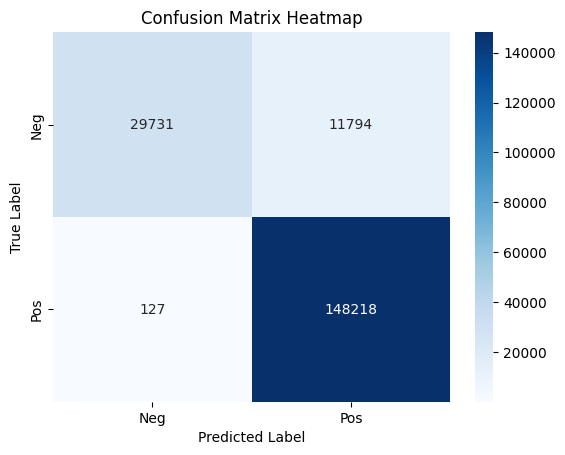

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

## **INSIGHT GENERATION AND VISUALIZATION**

The histogram shows a distribution of predicted probabilities. Most of the predictions are 1, indicating that most of the reviews are positive.

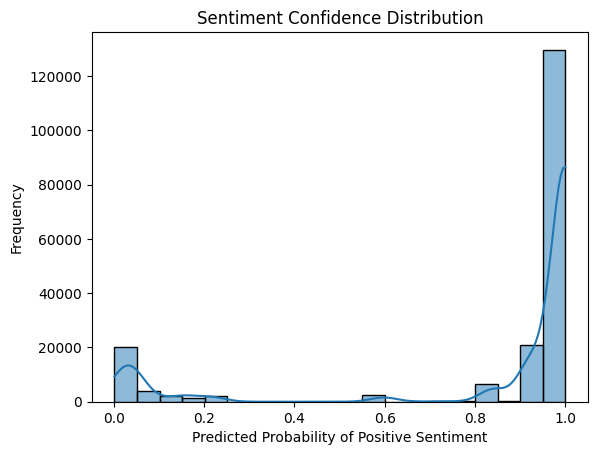

In [ ]:
from wordcloud import WordCloud

# Histogram
sns.histplot(df['predicted_prob'], bins=20, kde=True)
plt.title("Sentiment Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


A word cloud is a visual representation of text data, where the size of each word indicated its frequency in the corpus. Here, we use two word clouds to compare sentiments. We divide the corpus into positive and negative reviews, making two separate word clouds then observe the differences in the words used. This can help identify what most happy customers are happy with and what unhappy customers are dissatisfied with.

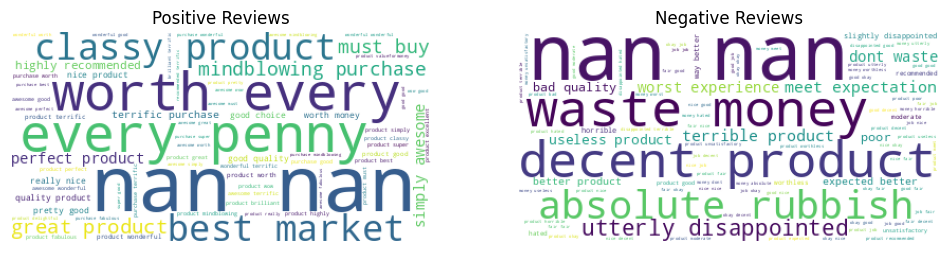

In [ ]:
# Word Clouds
positive_text = " ".join(df[df['label'] == 1]['final_text'])
negative_text = " ".join(df[df['label'] == 0]['final_text'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white').generate(positive_text))
plt.title("Positive Reviews")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='white').generate(negative_text))
plt.title("Negative Reviews")
plt.axis('off')

plt.show()